In [46]:
import os
import json
import warnings
import re
import pandas as pd
import numpy as np

from sys import getsizeof

import nltk # version 3.2.5
from nltk.corpus import stopwords
import emoji # version 0.4.5
from profanity import profanity # version 1.1
from wordcloud import WordCloud 
from collections import Counter
from toolz import valfilter

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
import seaborn as sns
sns.set_style("whitegrid")
sns.set(font_scale=1.2)
%matplotlib inline

warnings.filterwarnings('ignore')
nltk.download('stopwords');

[nltk_data] Downloading package stopwords to /Users/lia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Analysis

In [8]:
NEG_DATA_PATH = '../twitter-datasets/train_neg_full.txt'
POS_DATA_PATH = '../twitter-datasets/train_pos_full.txt'

In [9]:
def read_json(path):
    lines = []
    with open(path, "r") as doc:
        for line in doc:
            lines.append(line)
    return lines

In [10]:
raw_pos = pd.DataFrame(read_json(POS_DATA_PATH), columns=['raw_tweet'])
raw_pos['score'] = 1
raw_neg = pd.DataFrame(read_json(NEG_DATA_PATH), columns=['raw_tweet'])
raw_neg['score'] = -1
raw_tweets = pd.concat([raw_pos, raw_neg], axis=0)

In [11]:
print('Dataframe size: {size}MB \nDataframe shape: {shape}'
      .format(size=round(getsizeof(raw_tweets)/10**6, 2),
             shape=raw_tweets.shape))

Dataframe size: 374.92MB 
Dataframe shape: (2500000, 2)


In [12]:
print('# Positive: {pos}'.format(pos=(raw_tweets['score']==1).sum()))
print('# Negative: {neg}'.format(neg=(raw_tweets['score']==-1).sum()))

# Positive: 1250000
# Negative: 1250000


In [13]:
def preprocessing_text(series):
    """
    Clean elements of a series of string

    Parameters
    ----------
    series : series of strings

    Returns
    -------
    series with treated text

    """
    series = series.str.lower()

    series = series.str.replace('<user>', '')
    series = series.str.replace('<url>', '')
    
    series = series.str.replace('n\'t', 'not')
    series = series.str.replace('i\'m', 'i am')
    series = series.str.replace('\'re', ' are')
    series = series.str.replace('it\'s', 'it is')
    series = series.str.replace('that\'s', 'that is')
    series = series.str.replace('\'ll', ' will')
    series = series.str.replace('\'l', ' will')
    series = series.str.replace('\'ve', ' have')
    series = series.str.replace('\'d', ' would')
    series = series.str.replace('he\'s', 'he is')
    series = series.str.replace('she\'s', 'she is')
    series = series.str.replace('what\'s', 'what is')
    series = series.str.replace('who\'s', 'who is')
    series = series.str.replace('could\'ve', 'could have')
    series = series.str.replace('\'s', '')
    
    regex_letters = re.compile(r"[^\w\d\s]")
    series = series.str.replace(regex_letters, '')
    
    return series

In [16]:
def remove_stop_words(series):
    regex_stop = pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    series = series.str.replace(regex_stop, '')
    
    return series

In [17]:
def features_eng(df):
    df['count_user'] = df['raw_tweet'].str.count('<user>')
    df['count_url'] = df['raw_tweet'].str.count('<url>')
    df['count_!'] = df['raw_tweet'].str.count('!')
    df['count_?'] = df['raw_tweet'].str.count('\?')
    df['count_#'] = df['raw_tweet'].str.count('#')
#     df['count_tsk'] = df['raw_tweet'].str.count('tsk')
    df['count_<3'] = df['raw_tweet'].str.count('<3')
    df['count_lol'] = df['raw_tweet'].str.count('lol')
    df['count_words'] = df['clean_tweet'].str.split().str.len()
    
    # emojis
    emojis_list = map(lambda x: 
                      ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
    regex_emojis = re.compile('|'.join(re.escape(p) 
                                       for p in emojis_list))
#     df['count_emojis'] = df['raw_tweet'].str.count(regex_emojis)
    
    # bad words
    regex_bad = re.compile('|'.join(re.escape(p) 
                                       for p in profanity.get_words()))
    
    df['count_profanity'] = df['clean_tweet'].str.count(regex_bad)
                            
    return df

In [18]:
raw_tweets['treated_tweet'] = preprocessing_text(raw_tweets['raw_tweet'])
raw_tweets['clean_tweet'] = remove_stop_words(raw_tweets['treated_tweet'])
raw_tweets = features_eng(raw_tweets)

In [42]:
raw_tweets['nice_score'] = raw_tweets['score'].apply(lambda x: 'positive' if x==1 else 'negative')

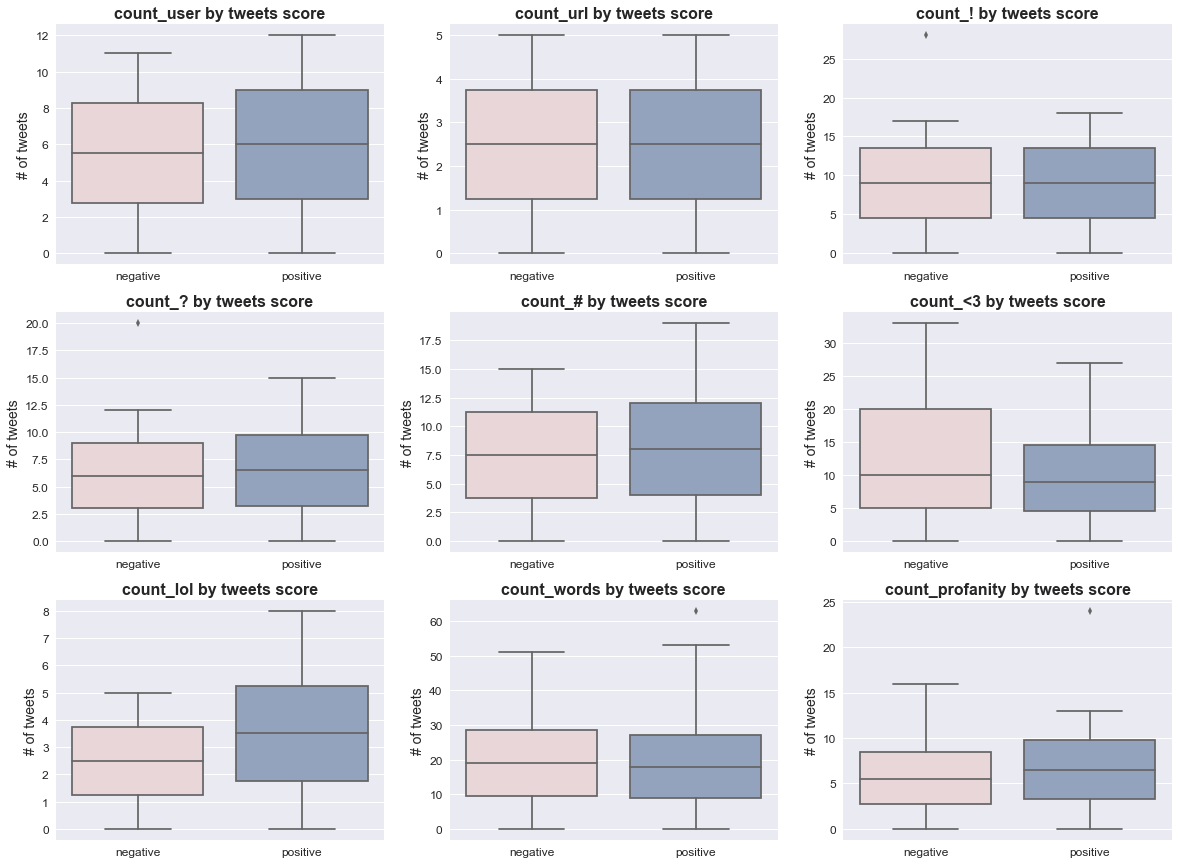

In [58]:
numeric_features = ['count_user', 'count_url', 'count_!', 'count_?',
                   'count_#', 'count_<3', 'count_lol', 'count_words', 'count_profanity']

f, ax = plt.subplots(3, 3, figsize=(20, 15))
positions = np.array(range(9)).reshape(3, 3)

for num_c, c in enumerate(numeric_features):
    pos = np.where(positions==num_c)
    g = (pd.DataFrame(raw_tweets.groupby([c, 'nice_score'])
                      .size())
         .reset_index())
    sns.boxplot(x='nice_score', y=c, data=g, saturation=0.3, 
                palette=['pink', 'cornflowerblue'], ax=ax[pos[0][0], pos[1][0]])
    ax[pos[0][0], pos[1][0]].set_title('{} by tweets score'.format(c), fontweight='bold', fontsize=16)
    ax[pos[0][0], pos[1][0]].set_ylabel('# of tweets', fontsize=14)
    ax[pos[0][0], pos[1][0]].set_xlabel('', fontsize=14)
    
    plt.savefig('figures/geral_descriptive_by_score.png')

In [62]:
pos = list(raw_tweets[raw_tweets.score==1]['clean_tweet'])
neg = list(raw_tweets[raw_tweets.score==-1]['clean_tweet'])

neg_cloud = WordCloud(width=1440, height=1080).generate(' '.join(neg));
pos_cloud = WordCloud(width=1440, height=1080).generate(' '.join(pos));

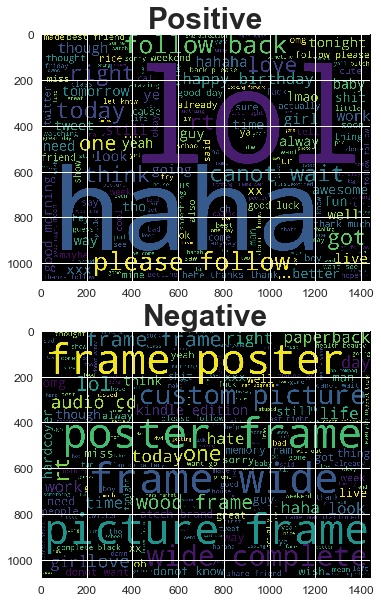

In [71]:
f, ax = plt.subplots(2, 1, figsize=(10, 10))

ax[0].imshow(pos_cloud);
ax[0].set_title('Positive', fontweight='bold', fontsize=30)
ax[1].imshow(neg_cloud);
ax[1].set_title('Negative', fontweight='bold', fontsize=30)
ax;
plt.savefig('figures/wordcloud_by_score.png')